In [13]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt

from tensorflow.keras import models, layers, Input, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.feature_extraction.text import CountVectorizer

from Code.utils.dataset import Dataset

In [2]:
def build_model(hp):
    min_hidden = 16
    max_hidden = 100

    n_features = X_train.shape[1]

    model = models.Sequential()
    model.add(Input((n_features,)))
    hp1_units = hp.Int('hidden1_units', min_value=min_hidden, max_value=max_hidden, step=8)
    model.add(layers.Dense(hp1_units, activation='relu'))
    hp2_units = hp.Int('hidden2_units', min_value=min_hidden, max_value=max_hidden, step=8)
    model.add(layers.Dense(hp2_units, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Tune the learning rate
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

    return model

In [3]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_output.csv')

# Remover pontuação deu pior resultado
X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets('Text', 'Label', sep='\t', rem_punctuation=False)

In [5]:
# Start tuner

tuner = kt.Hyperband(
    build_model,
    objective='acc',
    max_epochs=20,
    factor=3,
    directory='./KerasTuner',  # Directory to store results
    project_name='DNN_Tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

Trial 26 Complete [00h 00m 33s]
acc: 1.0

Best acc So Far: 1.0
Total elapsed time: 00h 05m 38s


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - acc: 0.8040 - loss: 0.4905 - val_acc: 0.9990 - val_loss: 0.0811
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - acc: 1.0000 - loss: 0.0638 - val_acc: 0.9990 - val_loss: 0.0287
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - acc: 1.0000 - loss: 0.0203 - val_acc: 0.9990 - val_loss: 0.0164
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - acc: 1.0000 - loss: 0.0104 - val_acc: 0.9990 - val_loss: 0.0119
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - acc: 1.0000 - loss: 0.0060 - val_acc: 0.9990 - val_loss: 0.0082
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - acc: 1.0000 - loss: 0.0039 - val_acc: 0.9990 - val_loss: 0.0072
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - acc: 1.0000 - loss: 0.0026 - val_acc: 0.9990 - val_loss: 0.0053
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - acc: 1.0000 - loss: 0.0019 - val_acc: 0.9990 - val_loss: 0.0047
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - acc: 1.0000 - loss: 0.0014 -

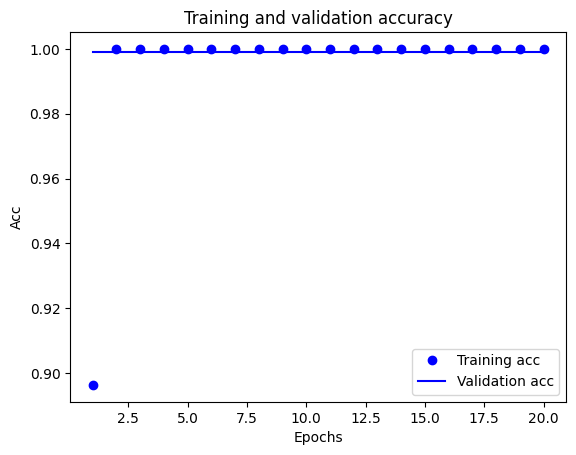

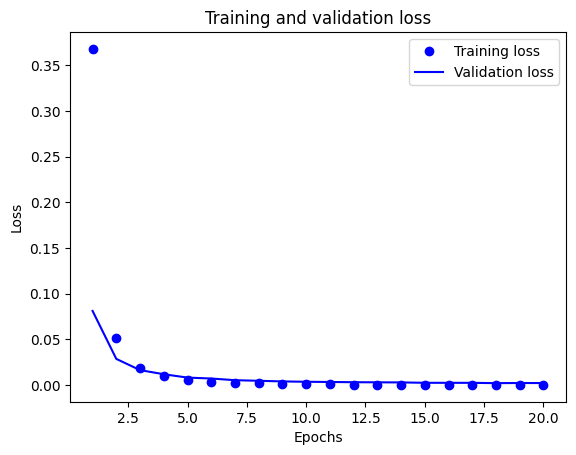

[0.0025586176197975874, 1.0]

In [12]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

n_features = X_train.shape[1]

hidden1_units = best_hps['hidden1_units']
hidden2_units = best_hps['hidden2_units']

print(f"Hidden Layer 1 has {hidden1_units} units")
print(f"Hidden Layer 2 has {hidden2_units} units")

model = models.Sequential()
model.add(Input((n_features,)))
model.add(layers.Dense(hidden1_units, activation='relu'))
model.add(layers.Dense(hidden2_units, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Tune the learning rate
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_validation, y_validation))

# Plot accuracy curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate Model
results = model.evaluate(X_test, y_test, verbose = 0)
results

In [19]:
''# Predict test dataset

out = model.predict(X_test)

if y_test is not None:
    print(model.evaluate(X_test, y_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - acc: 0.8000 - loss: 0.7471
[0.7470712065696716, 0.800000011920929]


In [21]:
# Store results

results_filepath = './Results/dnn_tuner_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, out)
results.to_csv(results_filepath, sep='\t', index=False)

In [18]:
dataset.set_dataset_test('../../Dataset/dataset1_inputs.csv', '../../Dataset/dataset1_outputs.csv')

X_test, y_test, ids = dataset.get_test_dataset('Text', 'Label', sep='\t', rem_punctuation=False)